## Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import xgboost as xgb

import seaborn as sns
sns.set(style="whitegrid")
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
X_train = pd.read_csv("X_train.csv", index_col=0)
X_test = pd.read_csv("X_test.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0).to_numpy().ravel() # Convert to 1D numpay array
y_test = pd.read_csv("y_test.csv", index_col=0).to_numpy().ravel() # Convert to 1D numpay array

In [3]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Linear regression

In [4]:
linear = LinearRegression()
linear.fit(X_train, y_train)
linear.score(X_train,y_train)
predict_linear = linear.predict(X_train)
print("Linear MSE train score: {:.5f}".format(mean_squared_error(y_train, predict_linear)))

Linear MSE train score: 0.11261


In [5]:
predict_linear = linear.predict(X_test)
print("Linear MSE test score: {:.5f}".format(mean_squared_error(y_test, predict_linear)))

Linear MSE test score: 0.09737


In [6]:
params = pd.read_csv("y_reverse_transformation.csv", index_col=0)
params = params.melt()
mean = float(params["variable"])
std = float(params["value"])
y_true = y_train*std+mean
true_predict = predict_linear*std+mean

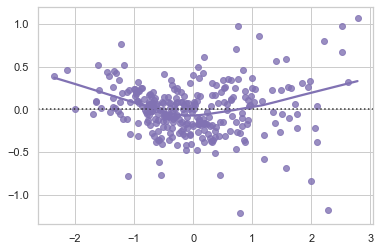

In [7]:
sns.residplot(predict_linear, y_test, lowess=True, color="m")

From the plot above we can observe **volatility**

### Lasso regression

In [8]:
spaceLasso = [Real(.0001, 1, name="alpha")]

In [9]:
@use_named_args(spaceLasso)
def objectiveLasso(**params):
    lasso["lasso"].set_params(**params)
    lasso.fit(X_train,y_train)
    return mean_squared_error(y_train, lasso.predict(X_train))

In [10]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=1))
res_lasso = gp_minimize(objectiveLasso, spaceLasso, n_calls=50, random_state=0)
print("Lasso MSE best train score: {:.5f}".format(res_lasso.fun))
print("At hyperparameters alpha = {}".format(res_lasso.x[0]))

Lasso MSE best train score: 0.11266
At hyperparameters alpha = 0.0001


In [11]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=1, alpha=res_lasso.x[0]))
lasso.fit(X_train,y_train)
predict_lasso = lasso.predict(X_test)
print("Lasso MSE test score: {:.5f}".format(mean_squared_error(y_test, predict_lasso)))

Lasso MSE test score: 0.09621


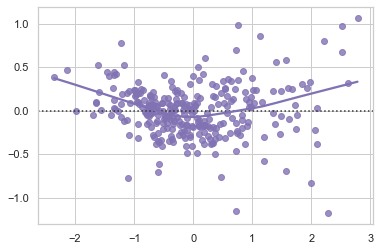

In [12]:
sns.residplot(predict_lasso, y_test, lowess=True, color="m")

### Elastic Net regularised regression

In [13]:
spaceENet  = [Real(0, 1, name="l1_ratio"),
              Real(.0001, 1, name="alpha")]

In [14]:
@use_named_args(spaceENet)
def objectiveENet(**params):
    ENet["elasticnet"].set_params(**params)
    ENet.fit(X_train,y_train)
    return mean_squared_error(y_train, ENet.predict(X_train))

In [15]:
ENet = make_pipeline(RobustScaler(), ElasticNet(random_state=1))
res_ENet = gp_minimize(objectiveENet, spaceENet, n_calls=50, random_state=0)
print("ElasticNet MSE best train score: {:.5f}".format(res_ENet.fun))
print("At hyperparameters l1 ratio = {} and alpha = {}".format(res_ENet.x[0], res_ENet.x[1]))

ElasticNet MSE best train score: 0.11262
At hyperparameters l1 ratio = 0.0 and alpha = 0.0001


In [16]:
ENet = make_pipeline(RobustScaler(), ElasticNet(l1_ratio=res_ENet.x[0], alpha=res_ENet.x[1], random_state=1))
ENet.fit(X_train,y_train)
predict_ENet = ENet.predict(X_test)
print("ElasticNet MSE test score: {:.5f}".format(mean_squared_error(y_test, predict_ENet)))

ElasticNet MSE test score: 0.09690


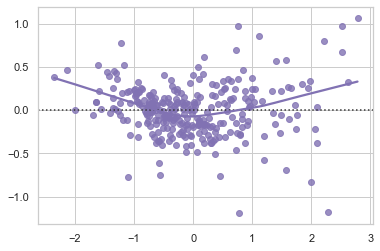

In [17]:
# Residual plot usinf seaborn
sns.residplot(predict_ENet, y_test, lowess=True, color="m")

### Kernel Ridge regression

In [18]:
spaceKRR  = [Real(1, 3, name="degree")]

In [19]:
@use_named_args(spaceKRR)
def objectiveKRR(**params):
    KRR.set_params(**params)
    KRR.fit(X_train,y_train)
    return mean_squared_error(y_train, KRR.predict(X_train))

In [20]:
KRR = KernelRidge(kernel='polynomial', alpha=0.5)
res_KRR = gp_minimize(objectiveKRR, spaceKRR, n_calls=50, random_state=0)
print("Kernel Ridge MSE best train score: {:.5f}".format(res_KRR.fun))
print("At hyperparameters degree = {}".format(res_KRR.x[0]))

Kernel Ridge MSE best train score: 0.03987
At hyperparameters degree = 3.0


In [21]:
KRR = KernelRidge(kernel='polynomial', degree=res_KRR.x[0], alpha=0.5)
KRR.fit(X_train,y_train)
predict_KRR = KRR.predict(X_test)
print("Kernel Ridge MSE test score: {:.5f}".format(mean_squared_error(y_test, np.nan_to_num(predict_KRR))))

Kernel Ridge MSE test score: 0.08150


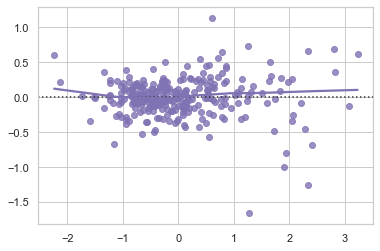

In [22]:
# Residual plot usinf seaborn
sns.residplot(predict_KRR, y_test, lowess=True, color="m")

### Gradient Boosting regression

In [23]:
spaceGBoost  = [Integer(2000, 3000, name="n_estimators"),
                Integer(1, 10, name="max_depth"),
                Integer(2, 5, name="min_samples_leaf"),
                Integer(2, 5, name="min_samples_split")]

In [24]:
@use_named_args(spaceGBoost)
def objectiveGBoost(**params):
    GBoost.set_params(**params)
    GBoost.fit(X_train,y_train)
    return mean_squared_error(y_train, GBoost.predict(X_train))

In [25]:
GBoost = GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state=0, learning_rate=0.01)
res_GBoost = gp_minimize(objectiveGBoost, spaceGBoost, n_calls=15, random_state=0)
print("GBoost MSE best train score: {:.5f}".format(res_GBoost.fun))
print("At hyperparameters n_estimators = {}, max_depth={}, min_samples_leaf={}, min_samples_split={}".format(res_GBoost.x[0],
                                                                                                             res_GBoost.x[1],
                                                                                                             res_GBoost.x[2],
                                                                                                             res_GBoost.x[3],))

GBoost MSE best train score: 0.00054
At hyperparameters n_estimators = 2991, max_depth=8, min_samples_leaf=2, min_samples_split=2


In [26]:
GBoost = GradientBoostingRegressor(learning_rate=0.01, n_estimators=res_GBoost.x[0], max_depth=res_GBoost.x[1],
                                   max_features='sqrt', min_samples_leaf=res_GBoost.x[2], min_samples_split=res_GBoost.x[3], 
                                   loss='huber', random_state=0)
GBoost.fit(X_train,y_train)
predict_GBoost = GBoost.predict(X_test)
print("Gradient Boosting MSE score: {:.5f}".format(mean_squared_error(y_test, predict_GBoost)))

Gradient Boosting MSE score: 0.10132


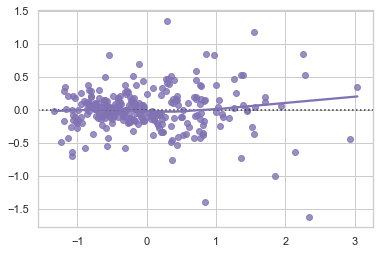

In [27]:
# Residual plot usinf seaborn
sns.residplot(predict_GBoost, y_test, lowess=True, color="m")

#### Linearity and Equal variance
<br>Can be tested by plotting residuals vs. predictions, where residuals are prediction errors.

In [28]:
# Residuals are calculated by subtracting original values with prediction values
residual = y_test - predict_GBoost

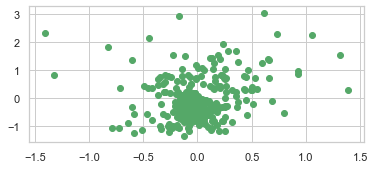

In [29]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(residual, predict_GBoost, color="g")

The residuals looks decent. Usually assumption violations are not independent of each other. Having one violations may lead to another.

**Normality probability plot**

We can apply normal probability plot to assess how the data (error) depart from normality visually.

0.9185915455944258

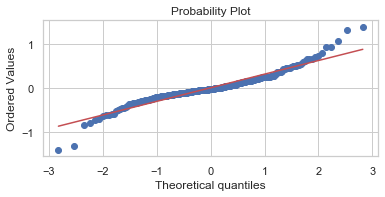

In [30]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

The good fit indicates that normality is a reasonable approximation.

### Stacking models with XGBoost

In [31]:
X_train_stacked = np.array((linear.predict(X_train), lasso.predict(X_train), ENet.predict(X_train),
                            KRR.predict(X_train), GBoost.predict(X_train))).T
X_test_stacked = np.array((linear.predict(X_test), lasso.predict(X_test), ENet.predict(X_test),
                           KRR.predict(X_test), GBoost.predict(X_test))).T

In [32]:
spaceXGB  = [Integer(5000, 10000, name="n_estimators"),
             Integer(1, 5, name="max_depth"),
             Real(0, 1, name="colsample_bytree")]

In [33]:
@use_named_args(spaceXGB)
def objectiveXGB(**params):
    XGBoost.set_params(**params)
    XGBoost.fit(X_train_stacked,y_train)
    return mean_squared_error(y_train, XGBoost.predict(X_train_stacked))

In [34]:
XGBoost = xgb.XGBRegressor(learning_rate=0.1, random_state = 0, nthread = -1, objective='reg:squarederror')
res_XGB = gp_minimize(objectiveXGB, spaceXGB, n_calls=10, random_state=0)
print("Xtreme GBoost + stacking MSE best train score: {:.5f}".format(res_XGB.fun))
print("At hyperparameters n_estimators = {}, max_depth={}, colsample_bytree={}".format(res_XGB.x[0],
                                                                                       res_XGB.x[1],
                                                                                       res_XGB.x[2],))

5.526377852458076e-06 [('n_estimators', 7964), ('max_depth', 4), ('colsample_bytree', 0.857945617622757)]
3.2104095956500605e-06 [('n_estimators', 9236), ('max_depth', 3), ('colsample_bytree', 0.38438170729269994)]
0.0009110935157140389 [('n_estimators', 6488), ('max_depth', 1), ('colsample_bytree', 0.27265629458011326)]
4.27984290937995e-06 [('n_estimators', 7388), ('max_depth', 4), ('colsample_bytree', 0.47997717237505744)]
1.7507262658135535e-06 [('n_estimators', 6964), ('max_depth', 4), ('colsample_bytree', 0.33739616041726844)]
1.1170315718704987e-05 [('n_estimators', 8241), ('max_depth', 2), ('colsample_bytree', 0.9571551589530466)]
4.279840530352195e-06 [('n_estimators', 5702), ('max_depth', 4), ('colsample_bytree', 0.4736080452737106)]
7.57880622144548e-06 [('n_estimators', 9005), ('max_depth', 3), ('colsample_bytree', 0.6788795301189604)]
5.383419480128217e-06 [('n_estimators', 8603), ('max_depth', 3), ('colsample_bytree', 0.5373732294490108)]
0.00040707874362356 [('n_estimato

In [35]:
XGBoost = xgb.XGBRegressor(learning_rate=0.1, random_state = 0, nthread = -1, objective='reg:squarederror',
                           n_estimators=res_XGB.x[0], max_depth=res_XGB.x[1], colsample_bytree=res_XGB.x[2])
XGBoost.fit(X_train_stacked,y_train)
predict_XGBoost = XGBoost.predict(X_test_stacked)
print("Xtreme Gradient Boosting +stacking MSE score: {:.5f}".format(mean_squared_error(y_test, predict_XGBoost)))

Xtreme Gradient Boosting +stacking MSE score: 0.08080
